In [1]:
import torchvision
import tarfile
import torch
import glob
import os

In [2]:
randon_seed = 47

# Download file

In [3]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose

In [4]:
transformer = Compose([
    ToTensor()
])
# transformer(img)

In [5]:
dataset = MNIST(root="./MN_data",download=True,train=True , transform=ToTensor())

D:\python\pytorch_transformer\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
from matplotlib.pyplot import *

<built-in method size of Tensor object at 0x0000017DE222C600>


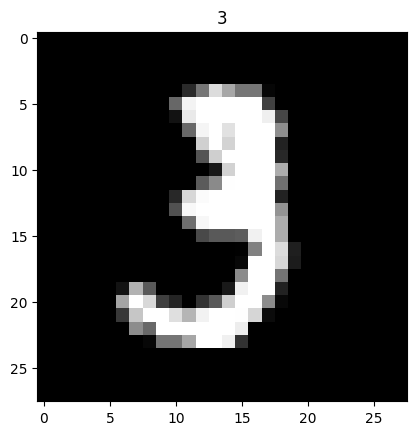

In [7]:
img, lbl = dataset[10]
imshow(img.permute(1,2,0),cmap="gray")
title(lbl)
print(img.size)

# Device

In [8]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
device

device(type='cuda')

# Random split

In [9]:
from torch.utils.data import random_split

In [10]:
torch.manual_seed(randon_seed)

In [11]:
val_per = 0.02
tes_per = 0.1
train_size, val_size, test_size = int(len(dataset)*(1-val_per-tes_per)), int(len(dataset)*val_per), int(len(dataset)*tes_per)

train_ds, val_ds, test_ds = random_split(dataset,[train_size, val_size, test_size])
print(len(train_ds),len(val_ds), len(test_ds))

52800 1200 6000


# DataLoader

In [12]:
from torch.utils.data.dataloader import DataLoader

In [13]:
batch_size = 128

In [14]:
train_dl = DataLoader(train_ds, batch_size,shuffle=True, num_workers=4,pin_memory=True)
val_dl   = DataLoader(val_ds  , batch_size,shuffle=True, num_workers=4,pin_memory=True)
test_dl  = DataLoader(test_ds , batch_size,shuffle=True, num_workers=4,pin_memory=True)
print(len(train_dl),len(test_dl))

413 47


# Model

In [15]:
import torch.nn as nn

In [16]:
def build_model():
    # input:28*28
    this_model = nn.Sequential(        # input  :28*28
        
        nn.Conv2d(1,16,3,padding=1),   # output :32*28*28
        nn.ReLU(),
        nn.Conv2d(16,32,3,padding=1),  # output :32*28*28
        nn.ReLU(),
        nn.MaxPool2d(2,2),             # output :32*14*14
        
        nn.Conv2d(32,64,3,padding=1),  # output :64*14*14
        nn.ReLU(),
        nn.Conv2d(64,128,3,padding=1), # output :128*14*14
        nn.ReLU(),
        nn.MaxPool2d(2,2),             # output : 128*7*7
        
        nn.Flatten(),
        nn.Linear(128*7*7, 1024),      # 1024
        nn.ReLU(),
        nn.Linear(1024,512),           # 512
        nn.ReLU(),
        nn.Linear(512,10)              # 10
    ).to(device)
    return this_model

In [17]:
model = build_model()

In [18]:
img.shape

torch.Size([1, 28, 28])

# Visulize the model

## torchviz

In [19]:
from torchviz import make_dot

In [29]:
y = model(img.unsqueeze(0).cuda())

In [37]:
make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=False, show_saved=False).render(
    "attached", format="svg")

'attached.svg'

## netron

In [42]:
import netron

In [43]:
if (not os.path.isdir("models")): os.mkdir("models")
torch.save(model.state_dict(), "models/netron.pth")

In [45]:
netron.start("models/netron.pth")

Serving 'models/netron.pth' at http://localhost:8080


('localhost', 8080)

## A screenshot of netron

<img src="netorn.png" />

# Train it

In [50]:
import torch.optim as optim
from tqdm.auto import tqdm

In [51]:
loss_fn    =  nn.CrossEntropyLoss()
optimizer  =  optim.Adam(model.parameters(),lr=0.001)

In [52]:
train_losses = []
valid_losses = []

In [53]:
num_epoch = 5

for epoch in range(1,num_epoch+1):
    
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################### train
    
    model.train()
    pro = tqdm(total=len(train_dl) + len(val_dl))
    for img, lbl in train_dl:
        img = img.cuda()
        lbl = lbl.cuda()
        optimizer.zero_grad()
        predict = model(img)
        
        loss = loss_fn(predict,lbl)
        loss.backward()
        optimizer.step()
        
        train_loss  +=  loss.item()*img.size(0)
        pro.update(1)
    
    
    
    ###################### val test
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    for img, lbl in val_dl:
        img = img.cuda()
        lbl = lbl.cuda()

        predict = model(img)
        loss = loss_fn(predict,lbl)

        valid_loss += loss.item()*img.size(0)
        
        
        # calculate accuracy
        _, predicted = torch.max(predict.data, 1)
        total       += lbl.size(0)
        accuracy    += (predicted == lbl).sum().item()
        
        pro.update(1)
    pro.close()
    
    
    accuracy = (100 * accuracy / total)
    
    
    train_loss = train_loss/len(train_dl.sampler) 
    valid_loss = valid_loss/len(test_dl.sampler)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print('Epoch:{} Train Loss:{:.4f} valid Losss:{:.4f} val acc:{:.2f}%'.format(epoch,train_loss,valid_loss,accuracy))    

  0%|          | 0/423 [00:00<?, ?it/s]

Epoch:1 Train Loss:0.2165 valid Losss:0.0105 val acc:98.42%


  0%|          | 0/423 [00:00<?, ?it/s]

Epoch:2 Train Loss:0.0474 valid Losss:0.0081 val acc:98.83%


  0%|          | 0/423 [00:00<?, ?it/s]

Epoch:3 Train Loss:0.0311 valid Losss:0.0078 val acc:98.75%


  0%|          | 0/423 [00:00<?, ?it/s]

Epoch:4 Train Loss:0.0219 valid Losss:0.0050 val acc:99.25%


  0%|          | 0/423 [00:00<?, ?it/s]

Epoch:5 Train Loss:0.0192 valid Losss:0.0039 val acc:99.58%


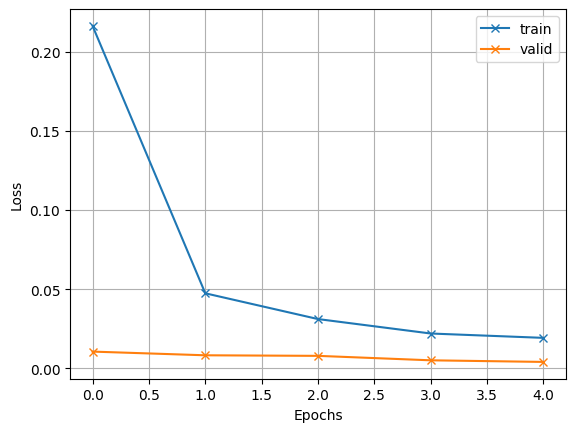

In [54]:
fig, ax = subplots(1)

ax.plot(train_losses,"x-",label='train')
ax.plot(valid_losses,"x-",label='valid')
grid()
xlabel("Epochs")
ylabel("Loss")

legend()

# test model

In [55]:
model.eval()
accuracy = 0.0
total = 0.0

pro = tqdm(total=len(test_dl))
for img, lbl in test_dl:
    # run the model on the test set to predict labels
    
    img = img.cuda()
    lbl = lbl.cuda()
    
    outputs = model(img)
    # the label with the highest energy will be our prediction
    _, predicted = torch.max(outputs.data, 1)
    total    += lbl.size(0)
    accuracy += (predicted == lbl).sum().item()
    pro.update(1)
pro.close()
# compute the accuracy over all test images
accuracy = (100 * accuracy / total)

  0%|          | 0/47 [00:00<?, ?it/s]

In [56]:
print(f"Final accuracy : {accuracy}%")

Final accuracy : 98.7%


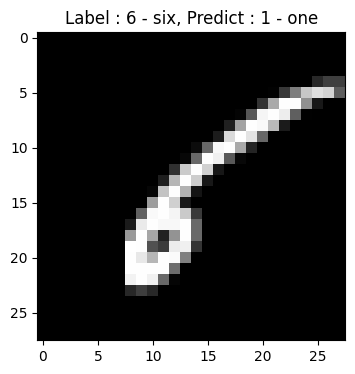

In [58]:
import random

# See which case did not predict success

while True:
    img, labels = dataset[random.randint(0,len(dataset))]
    predict = model(img.unsqueeze(0).to(device))
    _,predicted = torch.max(predict.data,dim=1)
    if ( dataset.classes[predicted[0].item()] != dataset.classes[labels]):
        figure(figsize=(4,4))
        imshow(img.permute(1,2,0),cmap="gray")
        title(f'Label : {dataset.classes[labels]}, Predict : {dataset.classes[predicted[0].item()]}')
        break
##

In [59]:
if (not os.path.isdir("models")): os.mkdir("models")
torch.save(model.state_dict(), "models/mnist.pth")

In [60]:
load_model = build_model()
load_model.load_state_dict(torch.load("models/mnist.pth"))
load_model.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=6272, out_features=1024, bias=True)
  (12): ReLU()
  (13): Linear(in_features=1024, out_features=512, bias=True)
  (14): ReLU()
  (15): Linear(in_features=512, out_features=10, bias=True)
)